# Memory Based Classification with KDM

A memory based classification model is a model that stores the training data and uses it to make predictions. The model is based on the idea that similar inputs have similar outputs. The model uses a similarity measure to find the most similar training examples to the input and then uses the output of those examples to make a prediction. 

[Kernel Density Matrices](https://github.com/fagonzalezo/kdm) represent a joint probability distribution of inputs and outputs as a set of points with associated weights. If we define the joint KDM using the whole dataset we have in fact a memory based classification model. A new input point is classified by finding the nearest neighbors in the KDM and using their outputs to make a prediction. It can be seen as a weighted k-nearest neighbors classifier, where the weights are given by a RBF kernel. The sigma parameter of the RBF kernel is a parameter of the model that can be learned from the data.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics


import numpy as np
import matplotlib.pyplot as plt

import kdm


In [2]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun



## Shallow Memory KDM Model

First, we will use a toy dataset to show how to use the KDM model. 



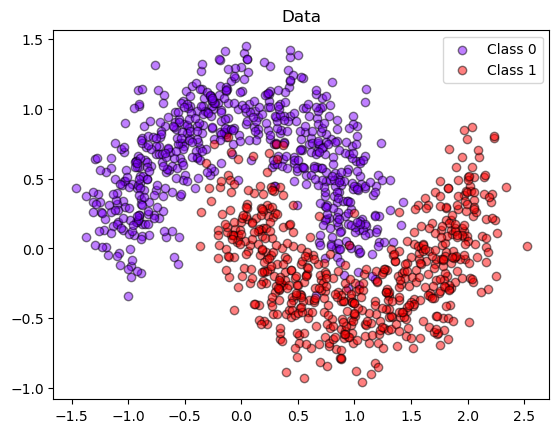

In [3]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

plot_data(X_train, y_train)

The KDM model is a memory-based classifier that uses a KDM layer that represents the joint probability of the inputs and outputs using a non-parametric KDM model. The KDM model can use a deep encoder, but in this case, we will use an identity, so the KDM model will be shallow. The KDM model has two important parameters the number of nearest neighbors to take intro account and the sigma parameter of the RBF kernel. The sigma parameter is initialized using the average distance of the nearest neighbors.

In [4]:
from kdm.models import MemKDMClassModelWrapper

encoded_size = 2
encoder = keras.layers.Identity()
dim_y = 2
n_comp = 200 # number of nearest neighbors to consider

mkdm_model = MemKDMClassModelWrapper(
                encoded_size=encoded_size,
                dim_y=dim_y,
                samples_x=X_train,
                samples_y=y_train,
                encoder=encoder,
                n_comp=n_comp,
                sigma=0.1)

sigma = mkdm_model.init_sigma(mult=1)
print("Initial sigma: ", sigma)

Building index...
Adding samples to index...
Initial sigma:  0.38518664240837097


Test Accuracy: 0.96
Validation Accuracy: 0.9575


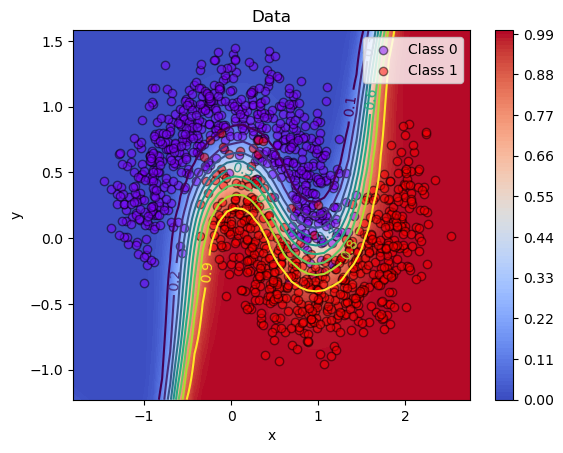

In [5]:
from sklearn.metrics import accuracy_score

pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

pred_y = mkdm_model.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)

The sigma parameter of the RBF kernel determines the weight of the neighbors in the prediction. If the sigma is small, only the nearest neighbors will have a significant weight in the prediction. If the sigma is large, all the neighbors will have a similar weight in the prediction. The sigma parameter can be learned from the data using a validation set.

In [6]:

# callbacks
from keras.callbacks import EarlyStopping


mkdm_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

earlystop = EarlyStopping(monitor='sparse_categorical_accuracy', patience=10,
                           mode='max', verbose=1, restore_best_weights=True)


print(f"Initial sigma: {mkdm_model.model.kernel.sigma.numpy()}")


mkdm_model.fit(X_val, y_val, epochs=50, verbose=0, callbacks=[earlystop])
# To train on the full train dataset, you can use the following line
# mkdm_model.fit(epochs=50, verbose=0, callbacks=[earlystop])

print(f"Final sigma: {mkdm_model.model.kernel.sigma.numpy()}")


Initial sigma: 0.38518664240837097
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
Final sigma: 0.1889827400445938


Test Accuracy: 0.9675
Validation Accuracy: 0.97


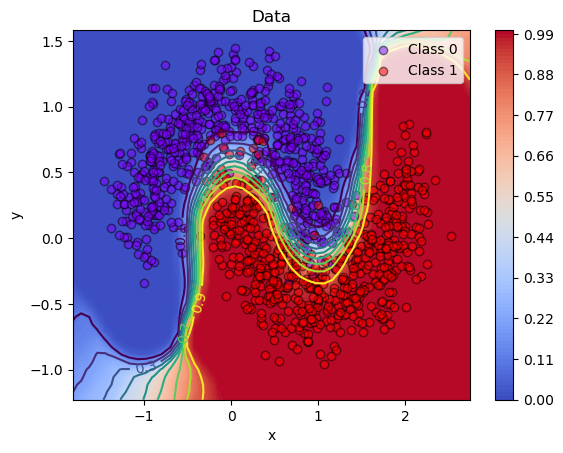

In [7]:
pred_y = mkdm_model.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

pred_y = mkdm_model.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

plot_decision_region(X, gen_pred_fun(mkdm_model))
plot_data(X_train, y_train)

## Fashion MNIST example

An example using the Fashion MNIST dataset. 

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

def display_imgs(x):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [11]:
tfkl = keras.layers

def create_encoder(input_shape, base_depth, encoded_size):
    encoder = keras.Sequential([
        tfkl.InputLayer(shape=input_shape),
        tfkl.Lambda(lambda x: x - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=keras.ops.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=keras.ops.leaky_relu),
        tfkl.Dense(encoded_size,
                activation=None),#, activity_regularizer=tf.keras.regularizers.l2(1e-3)),
        #tfkl.layers.LayerNormalization(),
        tfkl.Flatten(),
    ])
    return encoder

First we will train a KDMClassModel that learns a KDM with a limited number of components. This allows us to learn a good encoder and a good sigma parameter. 



In [12]:
from kdm.models import KDMClassModel

# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 64
encoder1 = create_encoder(input_shape, base_depth, encoded_size)

# warm up the encoder
enc_model = keras.Sequential([encoder1,
                keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

kdm_mnist = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_mnist.init_components(X_train[idx], keras.ops.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

# Compile the model
kdm_mnist.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('Untrained KDM test accuracy:', score[1])
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('Untrained KDM validation accuracy:', score[1])
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('Untrained KDM train accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.7504
Base encoder test accuracy: 0.8659999966621399
Base encoder train accuracy: 0.8816458582878113
Sigma: 1.3477370738983154
Untrained KDM test accuracy: 0.6452000141143799
Untrained KDM validation accuracy: 0.6519166827201843
Untrained KDM train accuracy: 0.6452000141143799
Sigma: 1.3477370738983154


We train the model for a couple of epochs, but it could be trained for more epochs to get better performance.

In [13]:
# create callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                           mode='max', verbose=1, restore_best_weights=True)

# Train the model
kdm_mnist.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=2, batch_size=128, verbose=1,
              callbacks=[earlystop])
# Evaluate the classifier
score = kdm_mnist.evaluate(X_train, y_train, verbose=0)
print('Trained KDM train accuracy:', score[1])
score = kdm_mnist.evaluate(X_val, y_val, verbose=0)
print('Trained KDM validation accuracy:', score[1])
score = kdm_mnist.evaluate(X_test, y_test, verbose=0)
print('Trained KDM test accuracy:', score[1])
print(f'Sigma: {kdm_mnist.kernel.sigma.numpy()}')

Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.8209 - val_loss: 0.3773 - val_sparse_categorical_accuracy: 0.8766
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - loss: 0.3296 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.3179 - val_sparse_categorical_accuracy: 0.8928
Restoring model weights from the end of the best epoch: 2.
Trained KDM train accuracy: 0.9094374775886536
Trained KDM validation accuracy: 0.8927500247955322
Trained KDM test accuracy: 0.8883000016212463
Sigma: 1.6777567863464355


Now we define the Memory KDM model that uses the encoder previously trained with the KDMClassModel and the whole train dataset.

In [14]:
from kdm.models import MemKDMClassModelWrapper

n_comp = 200

mkdm_mnist = MemKDMClassModelWrapper(
                encoded_size=encoded_size,
                dim_y=dim_y,
                samples_x=X_train,
                samples_y=y_train,
                encoder=encoder1,
                n_comp=n_comp,
                sigma=0.1)

mkdm_mnist.init_sigma(mult=1)

pred_y = mkdm_mnist.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

pred_y = mkdm_mnist.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))

Building index...
Adding samples to index...
Validation Accuracy: 0.9030833333333333
Test Accuracy: 0.8983


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2702 - sparse_categorical_accuracy: 0.9050
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9026
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9036
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2660 - sparse_categorical_accuracy: 0.9091
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2770 - sparse_categorical_accuracy: 0.9071
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2939 - sparse_categorical_accuracy: 0.9041
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9042
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9062
Epoch 9/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2770 - sparse_categorical_accuracy: 0.9084
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14

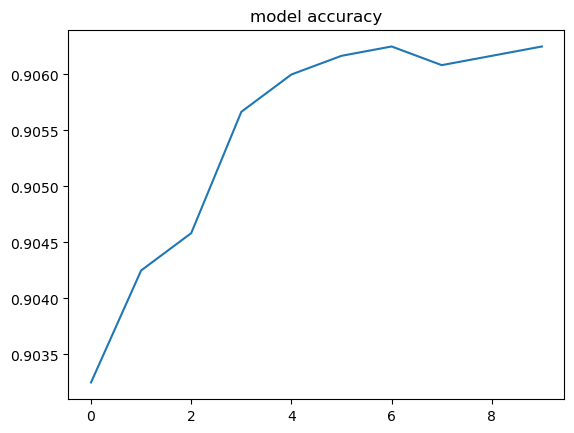

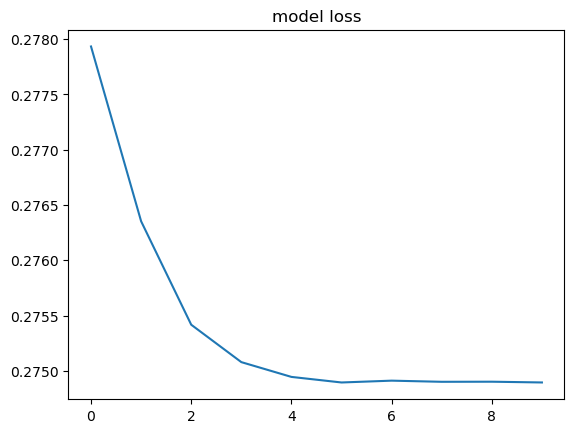

In [15]:
mkdm_mnist.compile(optimizer=optimizers.AdamW(learning_rate=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

earlystop = EarlyStopping(monitor='sparse_categorical_accuracy', patience=10,
                           mode='max', verbose=1, restore_best_weights=True)

sigma_ini = mkdm_mnist.model.kernel.sigma.numpy()

history = mkdm_mnist.fit(X_val, y_val, epochs=10, verbose=1, callbacks=[earlystop])

print(f"Initial sigma: {sigma_ini}")
print(f"Final sigma: {mkdm_mnist.model.kernel.sigma.numpy()}")

plt.title('model accuracy')
plt.plot(history.history['sparse_categorical_accuracy'])
plt.show()
plt.title('model loss')
plt.plot(history.history['loss'])
plt.show()


In [16]:
pred_y = mkdm_mnist.predict(X_val)
pred_y = np.argmax(pred_y, axis=1)
print("Validation Accuracy: {}".format(accuracy_score(y_val, pred_y)))

pred_y = mkdm_mnist.predict(X_test)
pred_y = np.argmax(pred_y, axis=1)
print("Test Accuracy: {}".format(accuracy_score(y_test, pred_y)))



Validation Accuracy: 0.90625
Test Accuracy: 0.8992


An advantage of a memory-based model is that predictions can be explained by looking at the nearest neighbors of the input. We can use the `predict_explain` method to get the nearest neighbors of an input along with the corresponding probabilities.

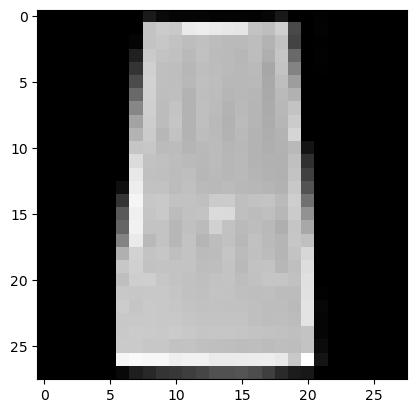

True label:  3
Predicted label:  6
Predicted probabilities:  [[0.41251937 0.01658988 0.0352571  0.10809712 0.00646874 0.
  0.42106774 0.         0.         0.        ]]


 Nearest neighbors


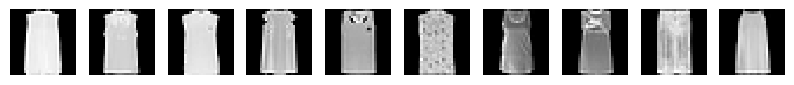

Labels:  [[6 6 2 3 0 6 0 0 1 0]]
Weights:  [[0.03054228 0.02961715 0.02116106 0.02075368 0.01887552 0.01559021
  0.01535568 0.01384687 0.01238008 0.01232497]]


In [18]:
# Look for a sample with a wrong prediction
for i in range(len(y_test)):
    if pred_y[i] != y_test[i]:
        # break with 0.1 probability
        if np.random.rand() < 0.1:
            break

plt.imshow(X_test[i], cmap='gray')
plt.show()
print("True label: ", y_test[i])
print("Predicted label: ", np.argmax(mkdm_mnist.predict(X_test[i: i + 1])))
print("Predicted probabilities: ", mkdm_mnist.predict(X_test[i:i + 1])) 

I, w = mkdm_mnist.predict_explain(X_test[i], 10)
X_neigh = np.take(X_train, I, axis=0)
y_neigh = np.take(y_train, I, axis=0)
print("\n\n Nearest neighbors")
display_imgs(X_neigh[0])
print("Labels: ", y_neigh)
print("Weights: ", w)